# Import

In [14]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models.segmentation as segmentation
import segmentation_models_pytorch as smp
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
from albumentations.core.composition import Compose

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Fuctions

## RLE decoding/encoding

In [15]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [16]:
# class SatelliteDataset(Dataset):
#     def __init__(self, csv_file, transform=None, infer=False): # transform 전처리하거나 다른 형태로 변환하는데 사용, infer 데이터를 추론 모드로 설정할지 여부
#         self.data = pd.read_csv(csv_file)
#         self.transform = transform
#         self.infer = infer

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         img_path = self.data.iloc[idx, 1] # 해당 인덱스에 위치한 데이터프레임의 두 번째 열(column)에 있는 이미지 경로를 가져옴
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         if self.infer:
#             if self.transform:
#                 image = self.transform(image=image)['image']
#             return image

#         mask_rle = self.data.iloc[idx, 2] # 데이터프레임의 idx 행에서 세 번째 열(column)에 있는 마스크 정보를 가져옴
#         mask = rle_decode(mask_rle, (image.shape[0], image.shape[1])) # 원래의 마스크 이미지로 변환

#         if self.transform:
#             augmented = self.transform(image=image, mask=mask) # 이미지와 마스크를 변환
#             image = augmented['image'] # 변환된 이미지를 딕셔너리에서 가져와 image 변수에 할당
#             mask = augmented['mask'] # 변환된 이미지를 딕셔너리에서 가져와 mask 변수에 할당

#         return image, mask

class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        if self.infer:
            return image

        return image, mask


## Loss Function

In [17]:
class FocalDiceLoss(nn.Module):
    def __init__(self, gamma=2, smooth=1e-6):
        super(FocalDiceLoss, self).__init__()
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Focal Loss 계산
        inputs_prob = torch.sigmoid(inputs)
        focal_loss = -targets * (1 - inputs_prob) ** self.gamma * torch.log(inputs_prob + self.smooth) \
                     - (1 - targets) * inputs_prob ** self.gamma * torch.log(1 - inputs_prob + self.smooth)
        focal_loss = focal_loss.mean()

        # Dice Loss 계산
        dice_target = targets
        dice_output = inputs_prob
        intersection = (dice_output * dice_target).sum()
        union = dice_output.sum() + dice_target.sum()
        dice_loss = 1 - (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Focal Loss와 Dice Loss를 더해서 총 손실을 계산
        total_loss = focal_loss + dice_loss

        return total_loss

# Model Define

In [18]:
model = segmentation.deeplabv3_mobilenet_v3_large(pretrained=True) # 사전 훈련된 deeplabv3 모델 가져옴, pretrained=True이면 모델이 사전 훈련된 가중치 사용하여 초기화됨
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1)) # 1*1 컨볼루션 레이어 생성, 입력 채널 256, 출력 채널 1로 설정
model = model.to(device)

criterion = FocalDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4) 

# Model Train

## Model save/load

In [22]:
save_dir = "./path/save/v3_mobilenet_plus_pspaug/"  # 모델 저장 디렉토리
model_name = "v3_mobilenet_plus_pspaug_trained_epoch{}.pth"  # 모델 파일 이름 패턴

# 훈련된 모델을 저장하는 함수
def save_model(model, epoch):
    save_path = save_dir + model_name.format(epoch)
    torch.save(model.state_dict(), save_path)
    print(f"Epoch {epoch} 모델 저장이 완료되었습니다.")

# 모델 불러오는 함수
def load_model(model, load_path):
    state_dict = torch.load(load_path)
    # 이전에 저장된 모델과 현재 모델 간 레이어 일치 여부 확인
    model_dict = model.state_dict()
    new_state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    model_dict.update(new_state_dict)
    model.load_state_dict(model_dict)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("모델 불러오기가 완료되었습니다.")

In [23]:
#그래프 생성 리스트 초기화
train_losses = []
val_losses = []

모델 불러오기가 완료되었습니다.


100%|██████████| 893/893 [04:52<00:00,  3.05it/s]


Epoch 24 모델 저장이 완료되었습니다.
Epoch 24, Training Loss: 0.4343173998550899, Training Accuracy: 0.949193885143343, Validation Loss: 0.37074717283248904, Validation Accuracy: 0.9600958625637755


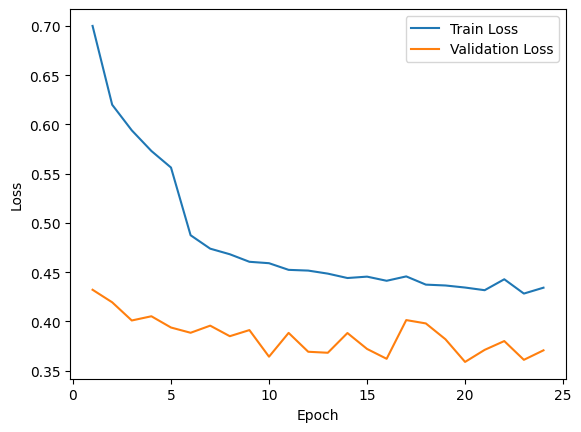

100%|██████████| 893/893 [05:46<00:00,  2.58it/s]


Epoch 25 모델 저장이 완료되었습니다.
Epoch 25, Training Loss: 0.4333649359952162, Training Accuracy: 0.9492230039337164, Validation Loss: 0.38739870429039003, Validation Accuracy: 0.9587976323341837


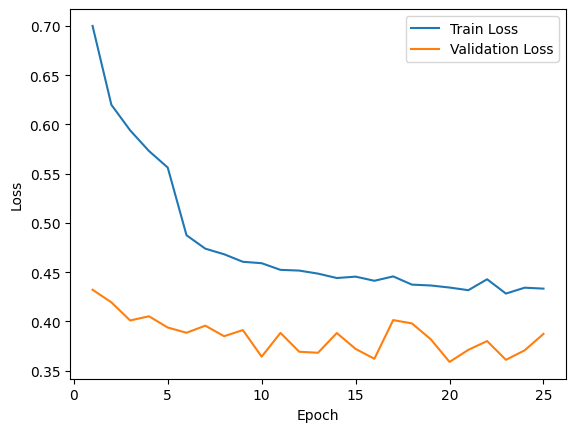

100%|██████████| 893/893 [05:21<00:00,  2.78it/s]


Epoch 26 모델 저장이 완료되었습니다.
Epoch 26, Training Loss: 0.4252175315463663, Training Accuracy: 0.9502405733498757, Validation Loss: 0.3851383101940155, Validation Accuracy: 0.9571061862244898


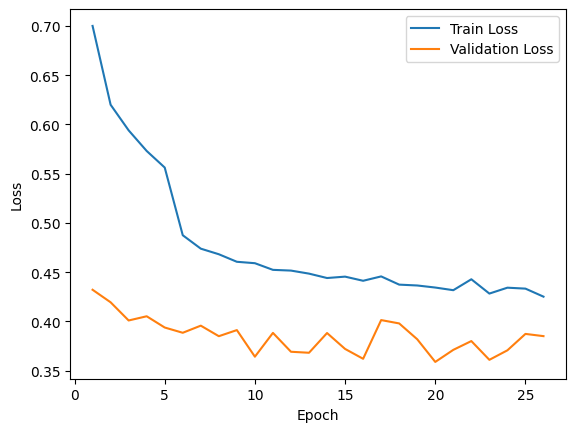

100%|██████████| 893/893 [05:02<00:00,  2.96it/s]


Epoch 27 모델 저장이 완료되었습니다.
Epoch 27, Training Loss: 0.42651481275662595, Training Accuracy: 0.9505609916957855, Validation Loss: 0.3894875717163086, Validation Accuracy: 0.9569126674107142


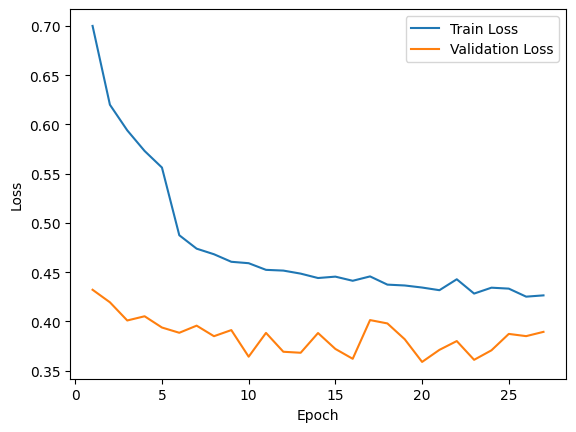

100%|██████████| 893/893 [04:56<00:00,  3.01it/s]


Epoch 28 모델 저장이 완료되었습니다.
Epoch 28, Training Loss: 0.42361230100322544, Training Accuracy: 0.9504516594584262, Validation Loss: 0.38839290380477903, Validation Accuracy: 0.957568359375


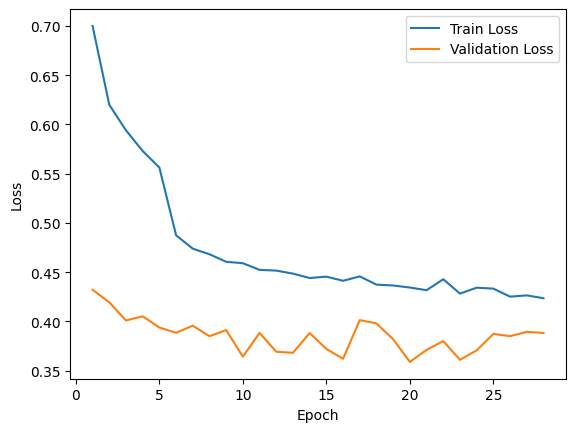

100%|██████████| 893/893 [05:02<00:00,  2.95it/s]


Epoch 29 모델 저장이 완료되었습니다.
Epoch 29, Training Loss: 0.4235942393941815, Training Accuracy: 0.9508133387283485, Validation Loss: 0.3679654896259308, Validation Accuracy: 0.960086894132653


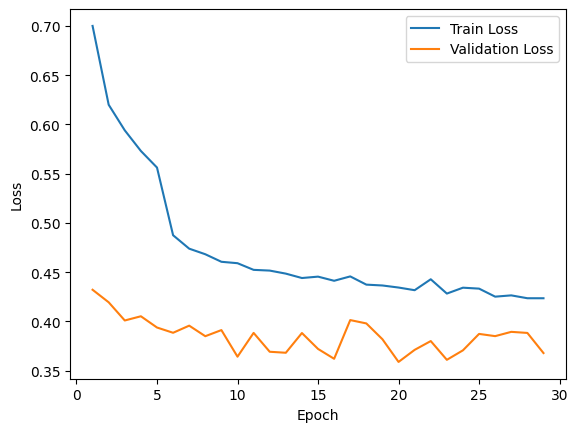

100%|██████████| 893/893 [04:52<00:00,  3.05it/s]


Epoch 30 모델 저장이 완료되었습니다.
Epoch 30, Training Loss: 0.43039132652998235, Training Accuracy: 0.9502420080755517, Validation Loss: 0.36711615562438965, Validation Accuracy: 0.9589953364158164


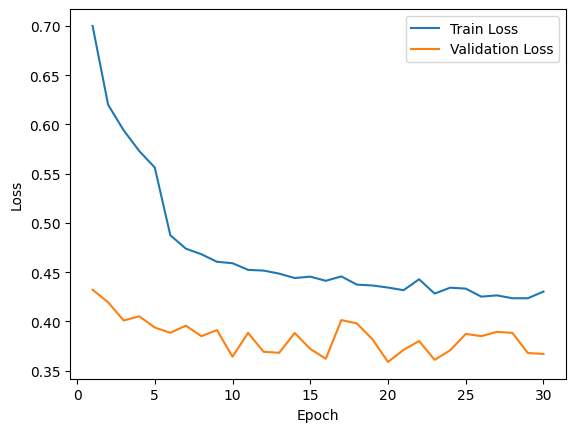

100%|██████████| 893/893 [05:14<00:00,  2.84it/s]


Epoch 31 모델 저장이 완료되었습니다.
Epoch 31, Training Loss: 0.423713996706057, Training Accuracy: 0.9509441667291917, Validation Loss: 0.3835390543937683, Validation Accuracy: 0.955358737244898


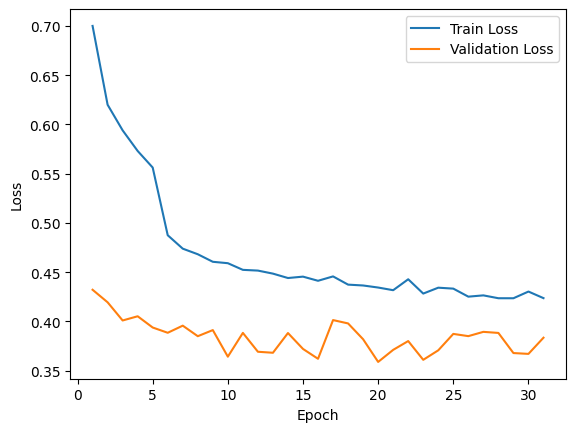

100%|██████████| 893/893 [05:11<00:00,  2.86it/s]


Epoch 32 모델 저장이 완료되었습니다.
Epoch 32, Training Loss: 0.4236442596387756, Training Accuracy: 0.9505418741157177, Validation Loss: 0.4020779550075531, Validation Accuracy: 0.9571723533163266


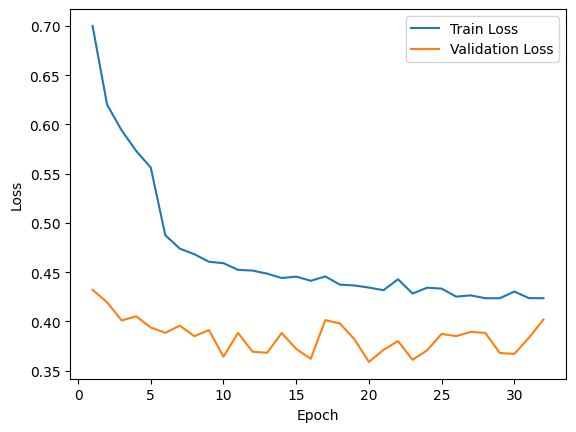

100%|██████████| 893/893 [05:11<00:00,  2.87it/s]


Epoch 33 모델 저장이 완료되었습니다.
Epoch 33, Training Loss: 0.4225414064937049, Training Accuracy: 0.951020648214643, Validation Loss: 0.3881832051277161, Validation Accuracy: 0.9583418367346939


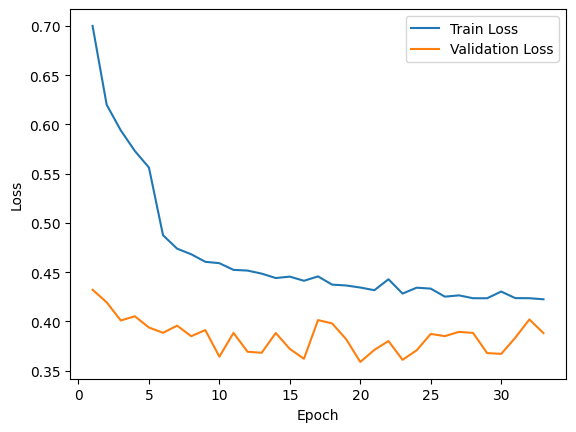

100%|██████████| 893/893 [05:11<00:00,  2.86it/s]


Epoch 34 모델 저장이 완료되었습니다.
Epoch 34, Training Loss: 0.4313512841971697, Training Accuracy: 0.9501129832513362, Validation Loss: 0.39024217128753663, Validation Accuracy: 0.957923509247449


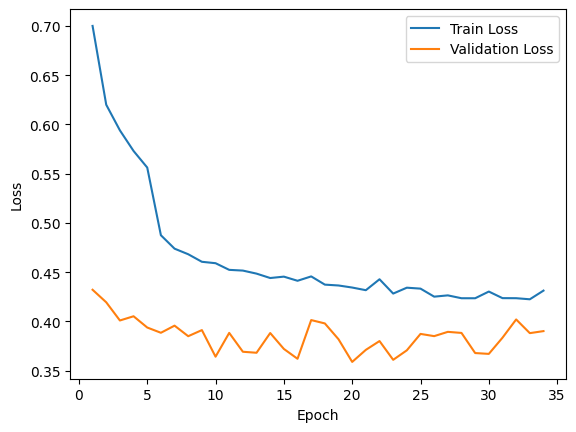

100%|██████████| 893/893 [05:02<00:00,  2.95it/s]


Epoch 35 모델 저장이 완료되었습니다.
Epoch 35, Training Loss: 0.4242176592249886, Training Accuracy: 0.9509771710023295, Validation Loss: 0.3763849139213562, Validation Accuracy: 0.9590921954719388


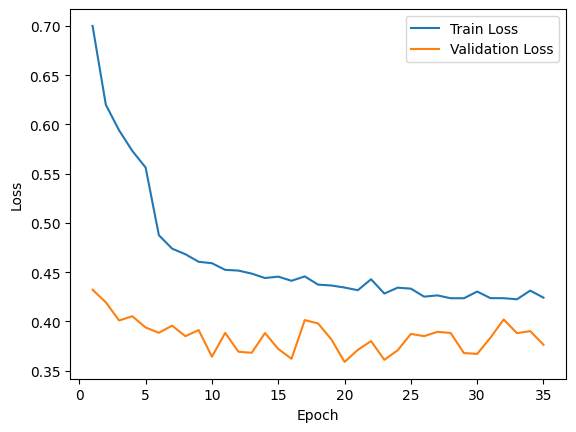

100%|██████████| 893/893 [05:10<00:00,  2.88it/s]


Epoch 36 모델 저장이 완료되었습니다.
Epoch 36, Training Loss: 0.42068513051459666, Training Accuracy: 0.9507566475250815, Validation Loss: 0.3828218245506287, Validation Accuracy: 0.9554757254464286


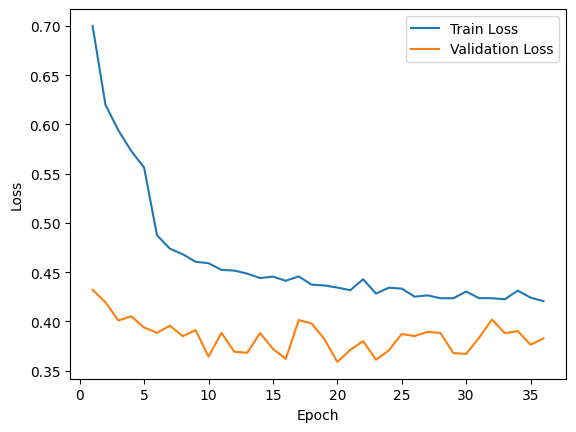

100%|██████████| 893/893 [06:10<00:00,  2.41it/s]


Epoch 37 모델 저장이 완료되었습니다.
Epoch 37, Training Loss: 0.4223003222587261, Training Accuracy: 0.9512494730034871, Validation Loss: 0.3800141143798828, Validation Accuracy: 0.9589166135204081


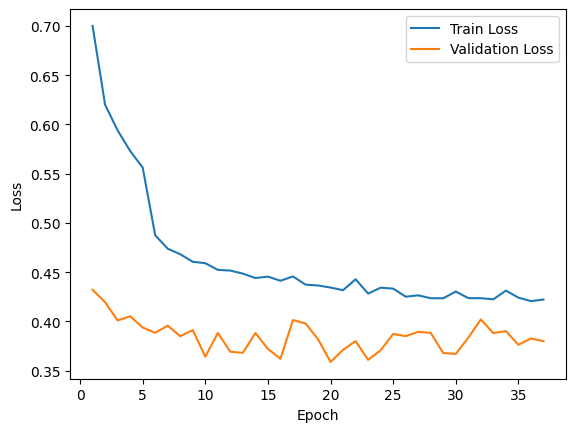

100%|██████████| 893/893 [06:49<00:00,  2.18it/s]


Epoch 38 모델 저장이 완료되었습니다.
Epoch 38, Training Loss: 0.42089873028362185, Training Accuracy: 0.9507481089534028, Validation Loss: 0.37517164945602416, Validation Accuracy: 0.9586294244260204


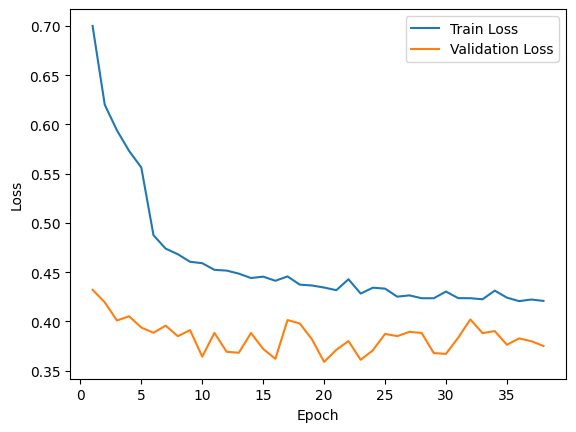

100%|██████████| 893/893 [06:59<00:00,  2.13it/s]


Epoch 39 모델 저장이 완료되었습니다.
Epoch 39, Training Loss: 0.4222669579080345, Training Accuracy: 0.9504716311747914, Validation Loss: 0.37587677121162416, Validation Accuracy: 0.9569268176020408


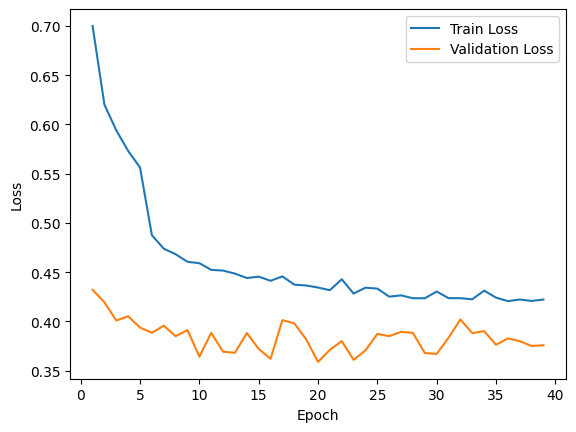

100%|██████████| 893/893 [07:50<00:00,  1.90it/s]


Epoch 40 모델 저장이 완료되었습니다.
Epoch 40, Training Loss: 0.42073815543734344, Training Accuracy: 0.9517772147921668, Validation Loss: 0.371263792514801, Validation Accuracy: 0.9604109534438775


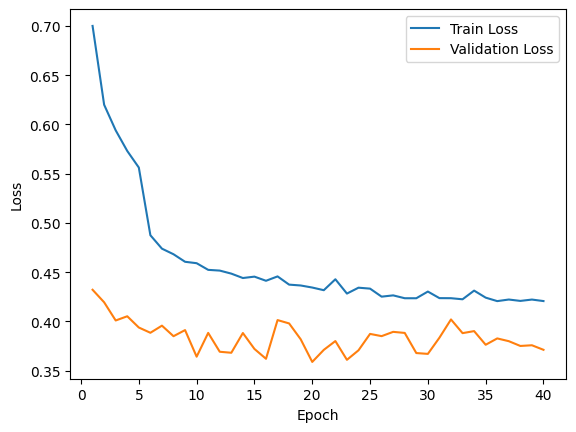

100%|██████████| 893/893 [05:48<00:00,  2.56it/s]


Epoch 41 모델 저장이 완료되었습니다.
Epoch 41, Training Loss: 0.4148782361695107, Training Accuracy: 0.951095122758925, Validation Loss: 0.3880393838882446, Validation Accuracy: 0.9570083306760204


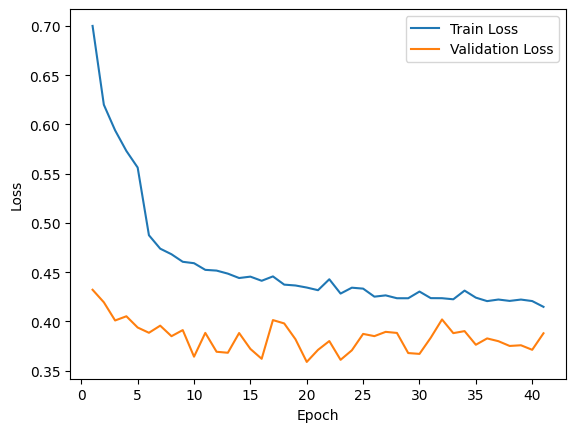

100%|██████████| 893/893 [05:07<00:00,  2.91it/s]


Epoch 42 모델 저장이 완료되었습니다.
Epoch 42, Training Loss: 0.42145468304632494, Training Accuracy: 0.9513388726026125, Validation Loss: 0.39716177701950073, Validation Accuracy: 0.9554735331632653


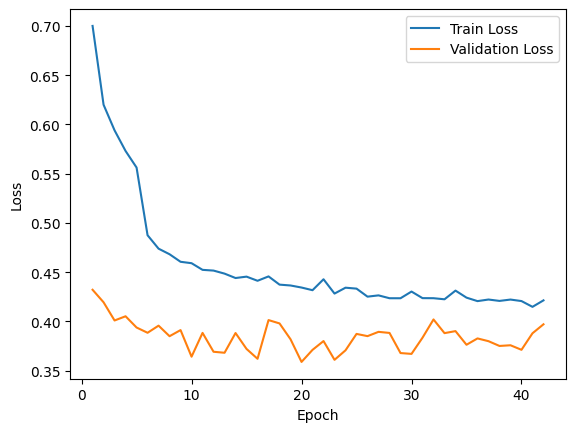

100%|██████████| 893/893 [05:08<00:00,  2.89it/s]


Epoch 43 모델 저장이 완료되었습니다.
Epoch 43, Training Loss: 0.4220499307384416, Training Accuracy: 0.950302891804043, Validation Loss: 0.39909843921661375, Validation Accuracy: 0.9543279655612245


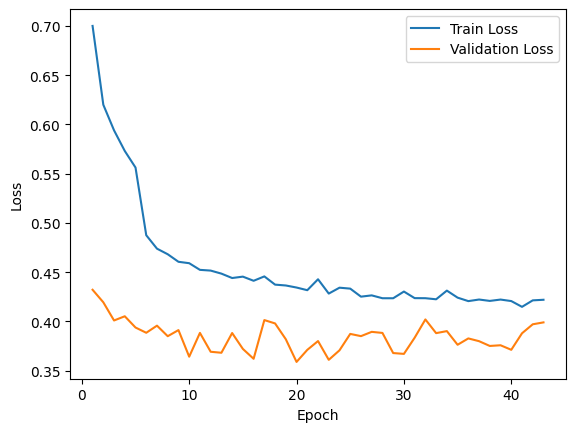

100%|██████████| 893/893 [05:40<00:00,  2.63it/s]


Epoch 44 모델 저장이 완료되었습니다.
Epoch 44, Training Loss: 0.4138333867371817, Training Accuracy: 0.9516557683341194, Validation Loss: 0.3711942279338837, Validation Accuracy: 0.960445631377551


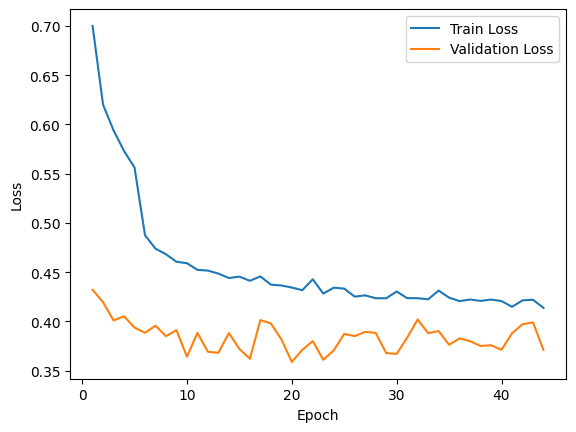

100%|██████████| 893/893 [07:28<00:00,  1.99it/s]


Epoch 45 모델 저장이 완료되었습니다.
Epoch 45, Training Loss: 0.40698174107715507, Training Accuracy: 0.9526436327879366, Validation Loss: 0.3816512608528137, Validation Accuracy: 0.9590601084183673


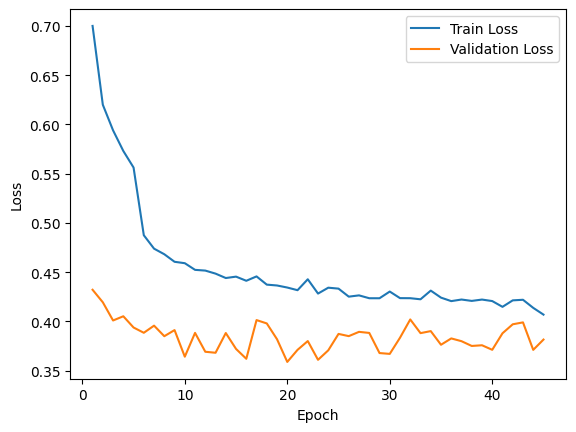

100%|██████████| 893/893 [07:34<00:00,  1.96it/s]


Epoch 46 모델 저장이 완료되었습니다.
Epoch 46, Training Loss: 0.41577472887340877, Training Accuracy: 0.9515130661639656, Validation Loss: 0.3678224349021912, Validation Accuracy: 0.9595735012755102


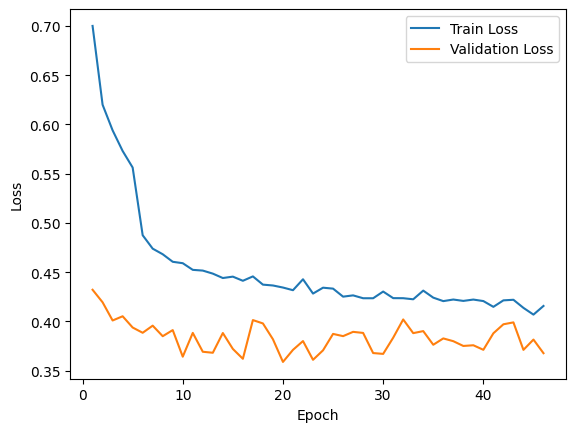

100%|██████████| 893/893 [07:42<00:00,  1.93it/s]


Epoch 47 모델 저장이 완료되었습니다.
Epoch 47, Training Loss: 0.4107717044009073, Training Accuracy: 0.9517596603373493, Validation Loss: 0.38402753591537475, Validation Accuracy: 0.9579243064413265


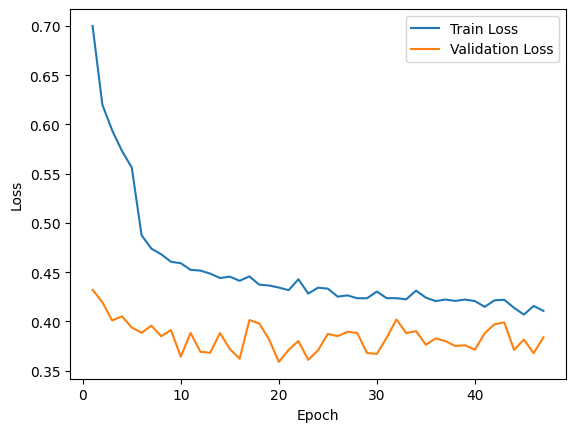

100%|██████████| 893/893 [07:20<00:00,  2.03it/s]


Epoch 48 모델 저장이 완료되었습니다.
Epoch 48, Training Loss: 0.41627675947323356, Training Accuracy: 0.9517676992672068, Validation Loss: 0.34701647400856017, Validation Accuracy: 0.9620095264668367


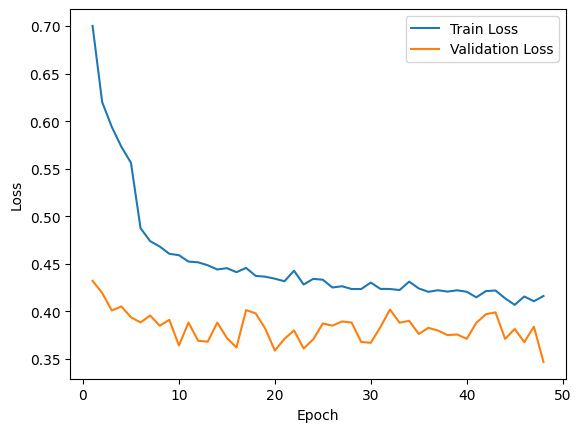

100%|██████████| 893/893 [05:25<00:00,  2.74it/s]


Epoch 49 모델 저장이 완료되었습니다.
Epoch 49, Training Loss: 0.4147521012273908, Training Accuracy: 0.9522195541162893, Validation Loss: 0.37398849248886107, Validation Accuracy: 0.9582110969387755


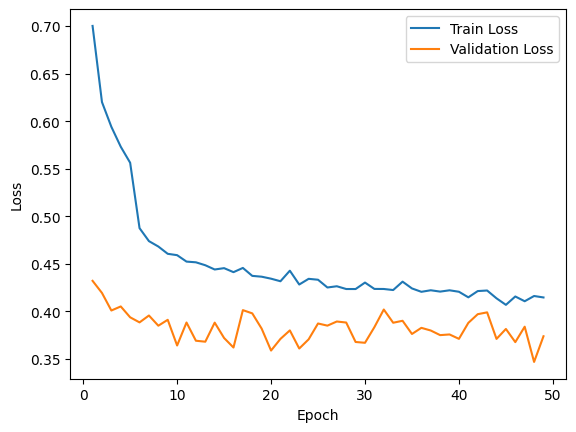

100%|██████████| 893/893 [05:03<00:00,  2.95it/s]


Epoch 50 모델 저장이 완료되었습니다.
Epoch 50, Training Loss: 0.4107999030713405, Training Accuracy: 0.9520996791573773, Validation Loss: 0.36783386826515196, Validation Accuracy: 0.9592617984693877


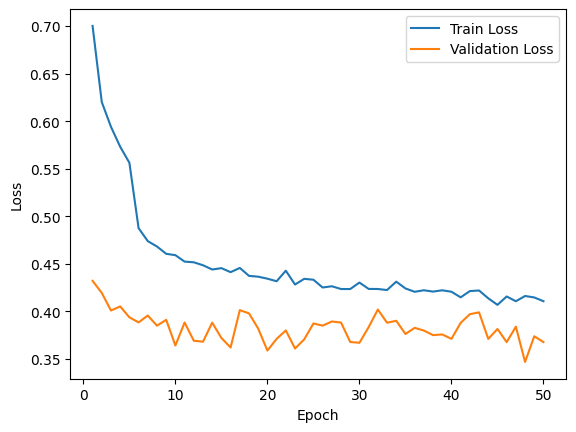

100%|██████████| 893/893 [04:59<00:00,  2.98it/s]


Epoch 51 모델 저장이 완료되었습니다.
Epoch 51, Training Loss: 0.41889533176934735, Training Accuracy: 0.9518452861055137, Validation Loss: 0.38042542457580564, Validation Accuracy: 0.9594485411352041


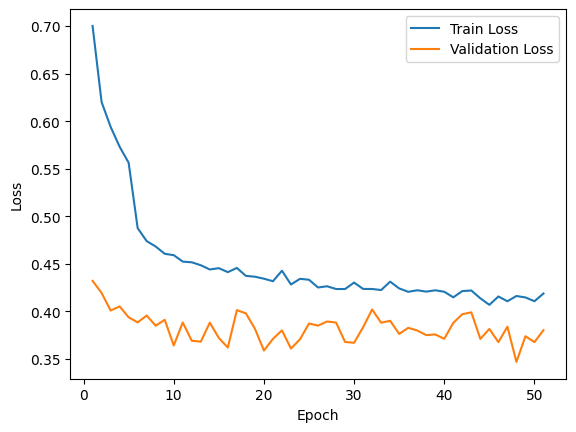

 21%|██        | 186/893 [00:59<03:44,  3.15it/s]


KeyboardInterrupt: 

In [26]:
# 이전에 저장된 모델을 불러옵니다.
load_path = "./path/save/v3_mobilenet_plus_pspaug/v3_mobilenet_plus_pspaug_trained_epoch23.pth"  # 이전에 저장된 모델 파일 경로
load_model(model, load_path)

for epoch in range(30): # 에폭
    epoch+=24
    model.train() # 학습 모드 설정
    epoch_loss = 0
    correct_pixels = 0
    total_pixels = 0
    correct_pixels_train = 0
    total_pixels_train = 0 

    # 데이터 증강을 위한 transform 파이프라인 정의
    transform = A.Compose(
        [
            A.CropNonEmptyMaskIfExists(height=224,width=224,p=0.7),
            # A.RandomCrop(width=224,height=224,p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=30,p=0.3),
            A.ColorJitter(p=0.3),
            A.ToGray(p=0.2),

            # # 고정값
            A.Resize(224, 224),  # 이미지 크기 조정
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 이미지 픽셀값 정규화
            ToTensorV2()  # 이미지를 텐서로 변환
        ]
    )

    val_transform = A.Compose(
        [
            # A.RandomCrop(width=224,height=224,p=0.7),
            # A.RandomRotate90(),  # 90도 회전 (랜덤하게)
            # A.HorizontalFlip(p=0.5),  # 수평 뒤집기 확률 50%
            # A.VerticalFlip(p=0.5),  # 수직 뒤집기 확률 50%
            # A.CLAHE(p=0.2),  # CLAHE를 통한 대비 개선

            # A.Resize(224, 224),  # 이미지 크기 조정
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 이미지 픽셀값 정규화
            ToTensorV2()  # 이미지를 텐서로 변환
        ]
    )

    dataset = SatelliteDataset(csv_file='./train.csv', transform=transform) # dataset 불러오기
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    val_dataset = SatelliteDataset(csv_file='./validation.csv', transform=val_transform)  # validation 데이터셋 로딩
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

    for images, masks in tqdm(dataloader):
        # GPU 디바이스로 데이터 이동
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad() # 옵티마이저에 누적된 변화도(gradient)를 초기화
        outputs = model(images)['out'] # 입력 이미지를 모델에 전달하여 모델의 출력을 계산
        loss = criterion(outputs, masks.unsqueeze(1)) # 모델의 출력과 정답 마스크 사이의 손실을 계산
        
        loss.backward() # 역전파를 통해 모델의 파라미터에 대한 손실 함수의 기울기(gradient)를 계산
        optimizer.step() # 옵티마이저를 사용하여 모델의 파라미터를 업데이트

        epoch_loss += loss.item() # 학습 과정에서 전체 에포크의 손실을 계산하기 위해 사용

        # 정확도 계산
        predicted_masks_train = (torch.sigmoid(outputs) > 0.5).float()
        correct_pixels_train += (predicted_masks_train == masks.unsqueeze(1)).sum().item()
        total_pixels_train += masks.numel()

    epoch_loss /= len(dataloader)
    accuracy_train = correct_pixels_train / total_pixels_train
    # training_loss_values[epoch]=epoch_loss

    # Validation 과정
    model.eval()  # 모델을 평가 모드로 설정 (Dropout 등의 레이어들이 평가 모드로 동작)
    total_validation_loss = 0.0
    correct_pixels_val = 0
    total_pixels_val = 0

    with torch.no_grad():  # 그라디언트 계산 비활성화
        for val_images, val_masks in val_dataloader:
            val_images = val_images.float().to(device)
            val_masks = val_masks.float().to(device)

            val_outputs = model(val_images)['out']
            val_loss = criterion(val_outputs, val_masks.unsqueeze(1))

            total_validation_loss += val_loss.item() * val_images.size(0)  # 배치 내 샘플 수로 스케일링

            # 정확도 계산
            predicted_masks_val = (torch.sigmoid(val_outputs) > 0.5).float()
            correct_pixels_val += (predicted_masks_val == val_masks.unsqueeze(1)).sum().item()
            total_pixels_val += val_masks.numel()


    average_validation_loss = total_validation_loss / len(val_dataset)
    accuracy_val = correct_pixels_val / total_pixels_val

    # 각 에폭이 끝날 때마다 모델 저장
    save_path = save_dir + model_name.format(epoch)
    torch.save(model.state_dict(), save_path)
    print(f"Epoch {epoch} 모델 저장이 완료되었습니다.")
    print(f'Epoch {epoch}, Training Loss: {epoch_loss}, Training Accuracy: {accuracy_train}, Validation Loss: {average_validation_loss}, Validation Accuracy: {accuracy_val}')
    
    train_losses.append(epoch_loss)
    val_losses.append(average_validation_loss)

    # Convert the loss values to numpy arrays using .cpu() method
    train_losses_np = torch.tensor(train_losses).cpu().numpy()
    val_losses_np = torch.tensor(val_losses).cpu().numpy()

    # Plot the losses after each epoch
    plt.plot(range(1, len(train_losses_np) + 1), train_losses_np, label='Train Loss')
    plt.plot(range(1, len(val_losses_np) + 1), val_losses_np, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Transform Define

In [ ]:
# albumentations 라이브러리를 사용하여 이미지 데이터에 대한 변환(transform) 파이프라인 정의
transform = A.Compose(
    [
        A.Resize(224, 224), # 이미지 크기 조정
        A.Normalize(), # 이미지 픽셀값 정규화
        ToTensorV2() # 이미지를 텐서로 변환
    ]
)

# Test Data Loader

In [ ]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
print(len(test_dataset))
print(len(test_dataloader))

60640
7580


# Load Model

In [ ]:
# 모델 생성
model = models.segmentation.deeplabv3_resnet50(pretrained=False,num_classes=1)

# 저장된 모델의 파라미터 불러오기 (strict=False 옵션 사용)
state_dict = torch.load('./path/save/resnet50_aug_l2_loss_focal_dice_batch8/deeplabv3_resnet50_focal_dice_batch8_trained_epoch40.pth', map_location=torch.device('cpu'))

# 저장된 모델의 클래스 수 (1개의 클래스일 때)
saved_num_classes = 1

# 현재 모델의 클래스 수 (예시로 21로 설정, 실제 사용하는 클래스 수로 수정)
current_num_classes = 1

# 모델의 분류기 레이어 크기 변경
if saved_num_classes != current_num_classes:
    # 모델의 분류기 레이어를 1x1 컨볼루션 레이어로 수정
    model.classifier[4] = torch.nn.Conv2d(256, current_num_classes, kernel_size=(1, 1), stride=(1, 1))
    # 모델의 분류기 레이어를 초기화
    torch.nn.init.xavier_uniform_(model.classifier[4].weight)  # 또는 다른 초기화 방법 사용

# 모델의 파라미터 로드
model.load_state_dict(state_dict, strict=False)

# GPU 사용이 가능한 경우에는 GPU로 데이터 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# Inference

In [ ]:
# 결과를 저장할 리스트 초기화
result = []

with torch.no_grad(): # 역전파 비활성화, 파라미터 업데이트 금지
    # print(len(test_dataloader))
    for images in tqdm(test_dataloader): # 데이터 로드
        images = images.float().to(device) 

        outputs = model(images)['out'] # 테스트 이미지 전달하여 예측 결과 얻음
        masks = torch.sigmoid(outputs).cpu().numpy() # outputs는 모델 예측 결과, 확률값으로 변환하기 위해 시그모이드 함수 적용한 후 각 픽셀 값을 0과 1사이의 확률값으로 변환하고, 넘파이 배열로 변환
        masks = np.squeeze(masks, axis=1) # 불필요한 차원 제거
        masks = (masks > 0.35).astype(np.uint8) # 최종 이진화 예측 마스크 얻음
        
        # print(len(images))
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i]) # RLE로 변환, mask_rle에 인코딩 결과 저장
            if mask_rle == '':
                result.append(-1) # 빌딩 없으면 -1 저장
            else:
                result.append(mask_rle) # 아니면 mask_rle 저장

            visualized_image = images[i].cpu().numpy().transpose((1, 2, 0)) # 이미지 시각화하기 위해 넘파이 배열로 가져옴
            masks_visualized = masks[i] * 255 # 이진화 마스크로 변환

            plt.subplot(1, 2, 1)
            plt.imshow(visualized_image)
            plt.title("Input Image")

            plt.subplot(1, 2, 2)
            plt.imshow(masks_visualized, cmap='gray')
            plt.title("Predicted Mask")

            plt.show()

100%|██████████| 7580/7580 [1:15:28<00:00,  1.67it/s]


In [ ]:
print(len(result))

60640


# Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv('./submit.csv', index=False)